<font color = 'red'>
Content: 

1. [Importing Libraries](#1)
1. [Clearing GPU Memory](#2)   
1. [Selecting Device](#3)
1. [Importing Dataset Directory and Show Examples](#4)
1. [Creating Deep Learning Model](#5)
1. [Initializing Hyperparameters and Functions](#6)
1. [Training and Visualizing Results](#7)
1. [Saving and Loading Model](#8)    
1. [Testing and Visualizing Results](#9)
1. [Testing on Video with OpenCV](#10)

<a id = "4"></a><br>

# Importing Libraries

Library are imported to semantic segmantation. we will use torch library and tools, numpy for matrix operations, pandas for data processing, matplotlib and PIL for visualizing.

In [ ]:

import numpy as np 
import pandas as pd 
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

<a id = "2"></a><br>

# Clearing GPU Memory

we will clear GPU memory

In [ ]:
torch.cuda.empty_cache()

<a id = "3"></a><br>

# Selecting Device

We select device. If GPU is available, we select GPU otherwise we select CPU. After that initialize device.

In [ ]:
if torch.cuda.is_available():
    print("GPU available")
    device = "cuda:0"
else:
    print("CPU available")
    device = "cpu"
    
device = torch.device(device)
print(device)

<a id = "4"></a><br>

# Importing Dataset Directory and Show Examples

we indicate data directory. We will use Train and validation.

In [ ]:
data_dir = os.path.join("/kaggle", "input", "cityscapes-image-pairs", "cityscapes_data")
train_dir = os.path.join(data_dir, "train") 
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)

print("train patch size:", len(train_fns))
print("validation patch size:", len(val_fns))

selected sample image from train data and Open image with Image class. each image has 256 rows and 512 columns. first 256 columns is image. Second 256 columns is label. we split image to image and label. Finally Variable was printed and was showed with imshow class.

In [ ]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)

def split_image(image):
    image = np.array(image)
    cityscape = image[:, :256, :] 
    label = image[:, 256:, :]
    return cityscape, label

sample_image = np.array(sample_image)
print("sample image shape: ",sample_image.shape)

cityscape, label = split_image(sample_image)
print("image shape:" , cityscape.shape)
print("label shape:" , label.shape)

cityscape = Image.fromarray(cityscape) 
label = Image.fromarray(label)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[1].imshow(cityscape)
axes[0].imshow(label)

we will show original image, label and label class in this section. Fistly we indicate color array as randomly. we will use Kmeans algorithm to predict label model. classes number is 10, iteration numbers is 1000. This is hyperparameter. you can change these two variables.

In [ ]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)
print(color_array[:5, :])

num_classes = 10
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

label_model.predict(color_array[:5, :])

cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)
print(label_class)

in this section, we will create Dataset class and we will use to initialize and data loader parts. CityscapeDataset class include five functions. Initialize, len, getitem, split image and transform.

in initialize function, we indicated variables for using other functions. These variables are image direcory, images list and label model.

in len function, we indicate list funtion's length.

in getitem function, we take image from image direcitory. Then image are opened and converted to RGB color format by Image class. After that image converted to array format. we will use split funtion, this function was explained. we will predict label model to indicate label class. Then we will use transform functions. Finally label class are converted to tensor. this function returns two variables: cityspace( original image) and label class.

in transform functions, there are two process. These process are converted to tensor and normalizing.

In [ ]:
class CityscapeDataset(Dataset):
    
    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.label_model = label_model
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        cityscape, label = self.split_image(image)
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label_class).long()
        return cityscape, label_class
    
    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

<a id = "5"></a><br>

# Creating Deep Learning Model

In this section, we create deep learning class. We will use UNet model.


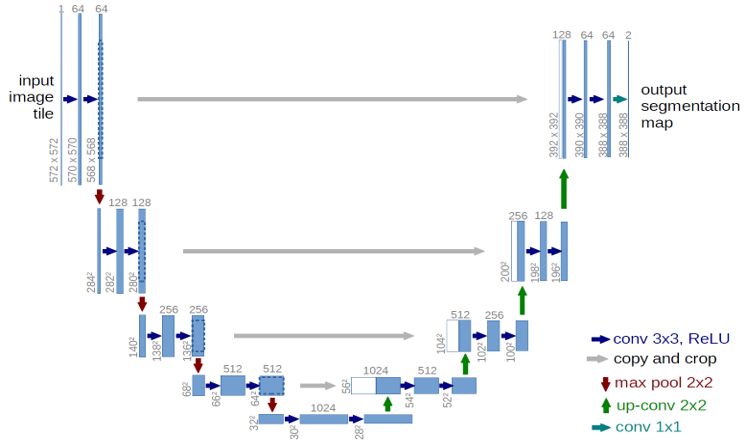

U-net architecture (example for 32x32 pixels in the lowest resolution). Each blue box corresponds to a multi-channel feature map. The number of channels is denoted on top of the box. The x-y-size is provided at the lower-left edge of the box. White boxes represent copied feature maps. The arrows denote the different operations.


In [ ]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) 
        contracting_12_out = self.contracting_12(contracting_11_out) 
        contracting_21_out = self.contracting_21(contracting_12_out) 
        contracting_22_out = self.contracting_22(contracting_21_out) 
        contracting_31_out = self.contracting_31(contracting_22_out) 
        contracting_32_out = self.contracting_32(contracting_31_out) 
        contracting_41_out = self.contracting_41(contracting_32_out) 
        contracting_42_out = self.contracting_42(contracting_41_out) 
        middle_out = self.middle(contracting_42_out) 
        expansive_11_out = self.expansive_11(middle_out) 
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1))
        expansive_21_out = self.expansive_21(expansive_12_out) 
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1))
        expansive_31_out = self.expansive_31(expansive_22_out) 
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1))
        expansive_41_out = self.expansive_41(expansive_32_out) 
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) 
        output_out = self.output(expansive_42_out) 
        return output_out

<a id = "6"></a><br>

# Initializing Hyperparameters and Functions

Hyperparameter selection is very important issue. There are three hyperparameters: batch size, epochs, learning rate.

In [ ]:
batch_size = 16
epochs = 30
lr = 0.001

In tıhs section, Dataset are initialized and loaded. After that, we initialize deep learning model and send GPU device. Final step, we indicate Loss and optimizer function.

In [ ]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size=batch_size)

model = UNet(num_classes=num_classes).to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

<a id = "7"></a><br>

# Training and Visualizing Results

In training section, we train our model. During training, we will to store step losses and epoch losses.

In [ ]:
step_losses = []
epoch_losses = []
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))

we visualize losses lists.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

<a id = "8"></a><br>

# Saving and Loading Model

In this section, our training mission is finished. After training process, we will save our model. If we test our model, we load pth file and initilize model. After that we  load model parameters from model.

In [ ]:
model_name = "U-Net.pth"
torch.save(model.state_dict(), model_name)
model_path = "/kaggle/working/U-Net.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<a id = "9"></a><br>

# Testing and Visualizing Results

In [ ]:
test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

X, Y = next(iter(data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

In [ ]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

print(sum(iou_scores) / len(iou_scores))

<a id = "10"></a><br>

# Testing on Video with OpenCV

In [ ]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
! pip install pixellib

# Mask RCNN

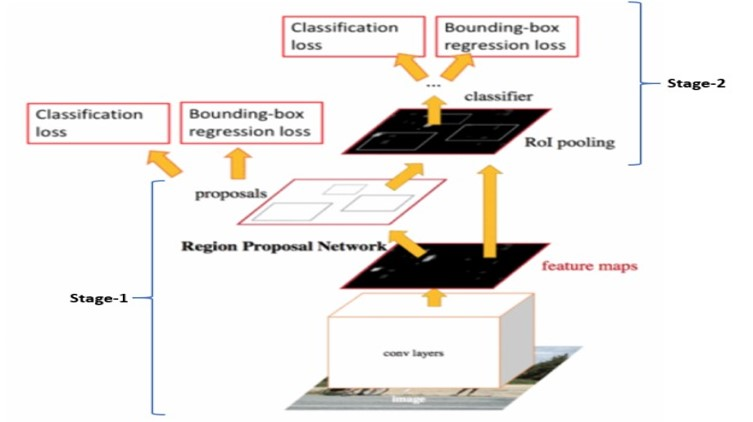
Mask R-CNN is a single, unified network for object detection

In [ ]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

In [ ]:
import pixellib
from pixellib.instance import instance_segmentation
import cv2

segment_video = instance_segmentation()
segment_video.load_model("mask_rcnn_coco.h5")
segment_video.process_video("../input/compact-dash/YI_Compact_Dash_Cam_1080p_Car_Dashcam_Sample_Video_Footage - 10Convert.com.mp4 (online-video-cutter.com).mp4", show_bboxes = False, frames_per_second= 15, output_video_name="traffic_monitor3.mp4")